<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/CNN_Airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D,MaxPooling1D
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

In [52]:
!pip install -U scikit-learn

In [53]:
from sklearn.metrics import mean_absolute_percentage_error

In [54]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2023-11-21 09:19:26--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2023-11-21 09:19:26 ERROR 403: Forbidden.



In [55]:
df = pd.read_csv("https://raw.githubusercontent.com/yeesem/Time-Series-Data-Analysis/main/airline_passengers.csv",index_col = 'Month',parse_dates = True)

In [56]:
df['LogPassengers'] = np.log(df['Passengers'])

In [57]:
df['DiffLogPassengers'] = np.log(df['LogPassengers']).diff()

In [58]:
NTest = 12
train = df.iloc[:-NTest]
test = df.iloc[-NTest:]

In [59]:
#boolean series to index df row
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

In [60]:
#Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []

for t in range(len(series) - T):
  x = series[t : t+T]
  X.append(x)
  y = series[t + T]
  Y.append(y)

In [61]:
X = np.array(X).reshape(-1,T,1)
Y = np.array(Y)
N = len(X)

In [62]:
XTrain,YTrain = X[:-NTest],Y[:-NTest]
XTest,YTest = X[-NTest:],Y[-NTest:]

In [63]:
#CNN
i = Input(shape = (T,1))
x = Conv1D(16,3,activation='relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32,3,activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1)(x)

model = Model(i,x)

In [64]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 8, 16)             64        
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4, 16)             0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 2, 32)             1568      
                                                                 
 global_max_pooling1d_2 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 1)                 33  

In [65]:
model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

In [66]:
r = model.fit(
    XTrain,
    YTrain,
    epochs = 100,
    validation_data = (XTest,YTest)
)

Epoch 1/100
4/4 [==============================] - 1s 62ms/step - loss: 4.4799e-04 - val_loss: 2.9526e-04
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 3.7616e-04 - val_loss: 2.8003e-04
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 3.2876e-04 - val_loss: 2.4028e-04
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 3.2347e-04 - val_loss: 2.2942e-04
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 3.0032e-04 - val_loss: 2.2157e-04
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 2.8708e-04 - val_loss: 2.2180e-04
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 2.7569e-04 - val_loss: 2.1605e-04
Epoch 8/100
4/4 [==============================] - 0s 12ms/step - loss: 2.6863e-04 - val_loss: 2.0310e-04
Epoch 9/100
4/4 [==============================] - 0s 18ms/step - loss: 2.5112e-04 - val_loss: 2.0737e-04
Epoch 10/100
4/4 [============================

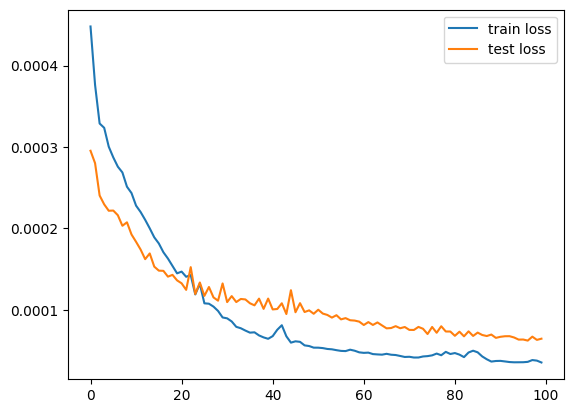

In [67]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label ='test loss')
plt.legend();

In [68]:
#First T + 1 values are not predictable
train_idx[:T+1] = False

In [69]:
PTrain = model.predict(XTrain).flatten()
PTest = model.predict(XTest).flatten()

1/1 [==============================] - 0s 23ms/step


In [70]:
#Store diff prediction
df.loc[train_idx,'Diff Train Prediction'] = PTrain
df.loc[test_idx,'Diff Test Prediction'] = PTest

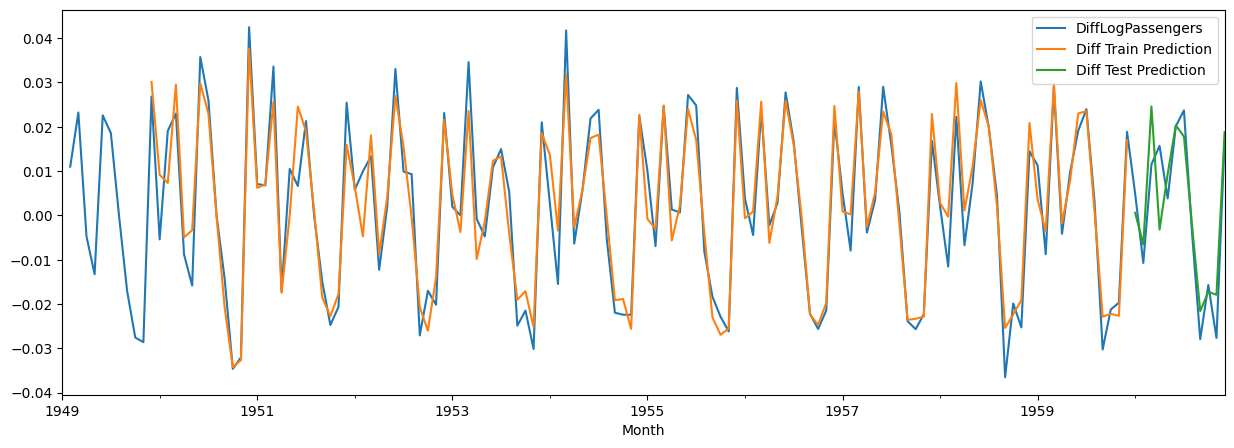

In [71]:
cols = [
    'DiffLogPassengers',
    'Diff Train Prediction',
    'Diff Test Prediction'
]
df[cols].plot(figsize = (15,5));

In [72]:
#Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [73]:
#Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [74]:
#1-step forecast
df.loc[train_idx,'1step_train'] = prev[train_idx] + PTrain
df.loc[test_idx,'1step_test'] = prev[test_idx] + PTest

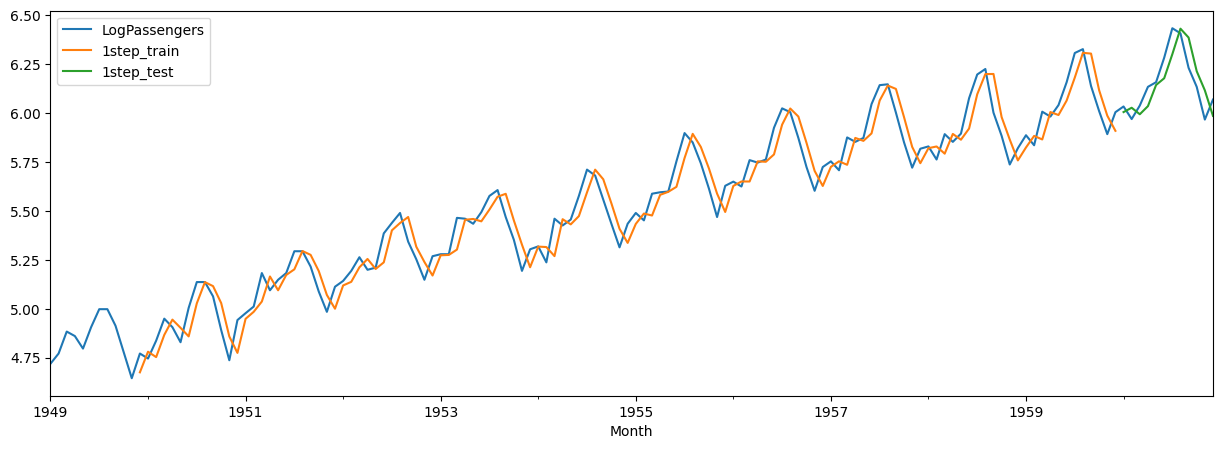

In [75]:
cols = [
    'LogPassengers',
    '1step_train',
    '1step_test'
]

df[cols].plot(figsize = (15,5));

In [79]:
#Multistep forecast
multistep_predictions = []

#First test input
last_x = XTest[0]

while(len(multistep_predictions) < NTest):
 p = model.predict(last_x.reshape(1,-1,1))[0]

 #Update the prediction list
 multistep_predictions.append(p)

 last_x = np.roll(last_x,-1)
 last_x[-1] = p

1/1 [==============================] - 0s 23ms/step


In [80]:
df.loc[test_idx,'multistep'] = last_train + np.cumsum(multistep_predictions)

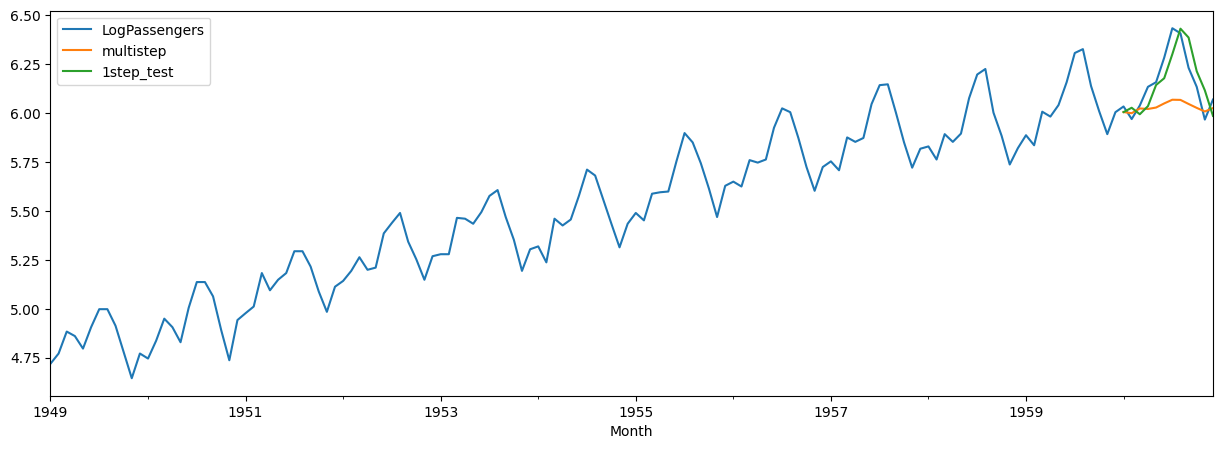

In [82]:
cols = [
    'LogPassengers',
    'multistep',
    '1step_test'
]
df[cols].plot(figsize = (15,5));

In [85]:
#Make multi-output supervised dataset
Tx = T
Ty = NTest
X = []
Y = []

for t in range(len(series) - Tx - Ty):
  x = series[t : t+Tx]
  X.append(x)
  y = series[t+Tx : t + Tx + Ty]
  Y.append(y)

X = np.array(X).reshape(-1,Tx,1)
Y = np.array(Y).reshape(-1,Ty)
N = len(X)
print("X shape: ",X.shape,' Y.shape: ',Y.shape)

X shape:  (121, 10, 1)  Y.shape:  (121, 12)


In [86]:
XTrain_m,XTest_m = X[:-1],Y[:-1]
XTest_m,YTest_m = X[-1:],Y[-1:]

In [87]:
#CNN
i = Input(shape = (Tx,1))
x = Conv1D(16,3,activation = 'relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32,3,activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i,x)

In [88]:
model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

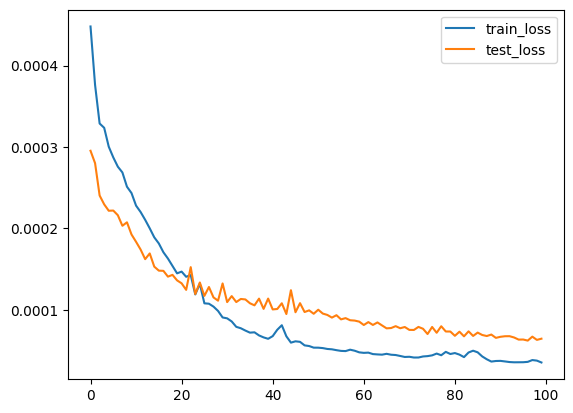

In [89]:
plt.plot(r.history['loss'],label = 'train_loss')
plt.plot(r.history['val_loss'],label = 'test_loss')
plt.legend();

In [90]:
PTrain = model.predict(XTrain_m)
PTest = model.predict(XTest_m)

1/1 [==============================] - 0s 31ms/step


In [91]:
PTrain.shape,PTest.shape

((120, 12), (1, 12))

In [98]:
PTrain = PTrain[:,0]
PTest = PTest[0]

In [99]:
df.loc[test_idx,'Diff Multi-Output Test Prediction'] = PTest

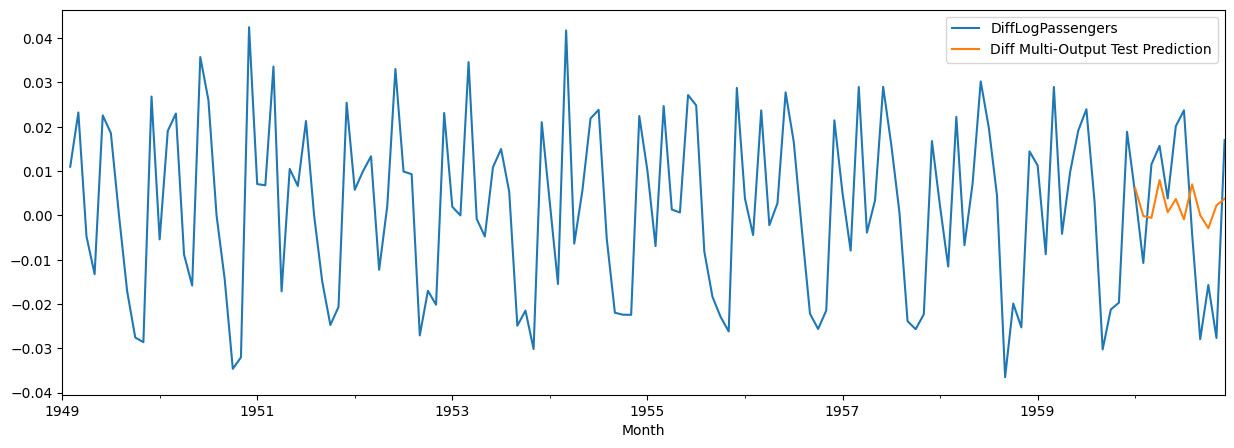

In [100]:
cols  = [
    'DiffLogPassengers',
    'Diff Multi-Output Test Prediction'
]
df[cols].plot(figsize = (15,5));

In [101]:
#Save multi-output forecast to dataframe
df.loc[test_idx,'multioutput'] = last_train + \
np.cumsum(PTest)

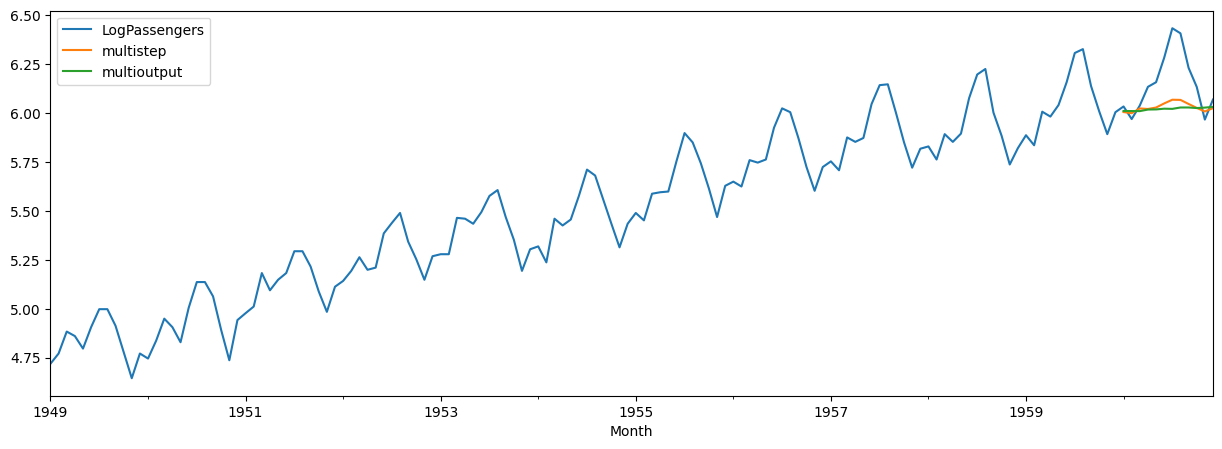

In [103]:
cols = [
    'LogPassengers','multistep','multioutput'
]
df[cols].plot(figsize = (15,5));

In [106]:
#MAPE
test_log_pass = df.loc[test_idx,'LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass,df.loc[test_idx,'multistep']
)
print('multi-step MAPE  :',mape1)

mape2 = mean_absolute_percentage_error(
    test_log_pass,df.loc[test_idx,'multioutput']
)
print('multi-output MAPE: ',mape2)

multi-step MAPE  : 0.021669102453570954
multi-output MAPE:  0.024019736178511285
